# INF-616 - Tarefa 4 - TF-IDF, seleção de características e redução de dimensionalidade

Professor: Jacques Wainer -- wainer@ic.unicamp.br  
Monitor: Lucas David -- ra188972@students.ic.unicamp.br

Instituto de Computação - Unicamp  
2018 

Alunos: Liselene Borges e Marcus Scarpim

In [1]:
import itertools

import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from IPython.display import display, HTML

from __future__ import print_function

pd.set_option('display.max_colwidth', -1)

%matplotlib inline

np.random.seed(9510)

In [2]:
# Algumas funções que podem ser úteis mais a frente:

def describe(x, y, classes):
    """Descreve um conjunto de dados.
    
    :param x: np.ndarray, as amostras no conjunto.
    :param y: np.ndarray, os rotulos associados as amostras `x`.
    :param classes: list, uma lista com os nomes de cada classe. 
    """
    samples, features = (len(x), len(x[0])) if isinstance(x, list) else x.shape

    _, counts = np.unique(y, return_counts=True)
    print('  frequência das classes:',
          *('    %s: %i' % e for e in zip(classes, counts)),
          sep='\n')

def show_datasets(x, y, classes, title):
    """Encontra um "embedding" de um conjunto que alinha as direções
       de maximiza separação das amostras com os eixos da base canônica,
       permitindo uma melhor vizualização do conjunto.
    
    :param x: np.ndarray, as amostras do conjunto.
    :param y: np.ndarray, os rotulos associados as amostras `x`.
    :param title: str, o titulo do conjunto a ser exibido.
    """
    x = TruncatedSVD(n_components=2).fit_transform(x)
    
    plt.figure(figsize=(12, 6))
    for c in np.unique(y):
        s = y == c
        plt.scatter(x[s][:, 0], x[s][:, 1], label=classes[c])
    plt.legend()
    plt.title(title)
    plt.axis('off')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de Confusão',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    width = max(6, len(classes))
    plt.figure(figsize=(width, width // 2))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')

def train_and_report(grid, train, test, classes):
    if not isinstance(grid, GridSearchCV):
        raise ValueError('Você deve passar um objeto da classe `GridSearchCV` '
                         'à função `train_and_report`. Ajuste seu modelo e sua '
                         'chamada apropriadamente.')
    grid.fit(*train)
    print('Melhores parâmetros:', grid.best_params_)
    print('Melhor pontuação sobre validação:', grid.best_score_)
    
    print('Resultados sobre a validação cruzada:')
    properties = ['params',
                  'mean_fit_time',
                  'rank_test_score',
                  'mean_test_score']
    display(pd.DataFrame({p: grid.cv_results_[p] for p in properties})
              .set_index('rank_test_score')
              .sort_index())

    print('Resultados sobre o teste:')
    p = grid.predict(test[0])
    print(metrics.classification_report(test[1], p))
    plot_confusion_matrix(metrics.confusion_matrix(test[1], p), classes,
                          normalize=True)

## Introdução ao 20 News Groups

In [3]:
# O codigo abaixo ira baixar e carregar o conjunto `20newsgroups`.
# Leia sobre este conjunto aqui: http://scikit-learn.org/stable/datasets/twenty_newsgroups.html

train, test = (datasets.fetch_20newsgroups(subset=subset, shuffle=True)
               for subset in ('train', 'test'))

print('Algumas amostras em 20 News Groups:')
samples_to_show = 10
display(pd.DataFrame({'article': [a[320:370] for a in train.data[:samples_to_show]],
                      'label': np.asarray(train.target_names)[train.target[:samples_to_show]]}))

print('Conjunto 20 News Groups treino:')
describe(train.data, train.target, train.target_names)

Algumas amostras em 20 News Groups:


,article,label
0,arly 70s. It was called a Bricklin. The doors were,rec.autos
1,who upgraded their SI clock oscillator have\nshare,comp.sys.mac.hardware
2,bit sooner than i intended to be...\n\ni'm looking,comp.sys.mac.hardware
3,ass1.iastate.edu>:\n> > Anyone know about the Weite,comp.graphics
4,"acs1.ttu.edu (Pack Rat) writes...\n>>>""Clear cautio",sci.space
5,article <1qv87v$4j3@transfer.stratus.com> cdt@sw.,talk.politics.guns
6,"because of mail-bouncing probs (Sean, Debra, and",sci.med
7,"93:29 ""Although SCSI is twice as fasst as ESDI,\n>>",comp.sys.ibm.pc.hardware
8,,comp.os.ms-windows.misc
9,that it is a\n>\thardware compression board that wo,comp.sys.mac.hardware


Conjunto 20 News Groups treino:
  frequência das classes:
    alt.atheism: 480
    comp.graphics: 584
    comp.os.ms-windows.misc: 591
    comp.sys.ibm.pc.hardware: 590
    comp.sys.mac.hardware: 578
    comp.windows.x: 593
    misc.forsale: 585
    rec.autos: 594
    rec.motorcycles: 598
    rec.sport.baseball: 597
    rec.sport.hockey: 600
    sci.crypt: 595
    sci.electronics: 591
    sci.med: 594
    sci.space: 593
    soc.religion.christian: 599
    talk.politics.guns: 546
    talk.politics.mideast: 564
    talk.politics.misc: 465
    talk.religion.misc: 377


**Vamos binarizar o problema:**

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.classes_ = train.target_names

computing_classes, rec_classes = ([t for t in train.target_names if tag in t]
                                   for tag in ('comp.', 'soc.religion.'))
computing_codes, rec_codes = (le.transform(t)
                              for t in (computing_classes, rec_classes))

binary_set = []

for (data, target) in ((train.data, train.target), (test.data, test.target)):
    computing_samples = np.in1d(target, computing_codes)
    rec_samples = np.in1d(target, rec_codes)
    
    x0 = [tx for tx, selected in zip(data, computing_samples) if selected]
    x1 = [tx for tx, selected in zip(data, rec_samples) if selected]
    
    binary_set += [(x0 + x1, np.concatenate((np.zeros(len(x0)), np.ones(len(x1)))))]

(x_train, y_train), (x_test, y_test) = binary_set
target_names = ['computação', 'religião']

In [5]:
print((y_train == 0).sum(), 'artigos relacionadas à computação')
print((y_train == 1).sum(), 'artigos relacionados à religião')

2936 artigos relacionadas à computação
599 artigos relacionados à religião


## Processando texto com o TF-IDF

1. **Vetorize as amostras de texto em *20newgroups* em um conjunto de características utilizando o TF-IDF. Utilize as palavras de parada da lingua inglesa.**

2. **Em seguida, remova todas as features que não possuam uma variância maior ou igual à $t = 1e^{-4}$.**

3. **Finalmente, treine um classificador `LogisticRegression` buscando por valores de `C` no intervalo *(100, 10,000)***

Dica: use o parâmetro `verbose=2` quando iniciar o grid-search. Isso lhe dará uma ideia do progresso da busca, caso ela tome muito tempo.

Bônus: tente executar todas ações de uma única vez, utilizando a classe `Pipeline`!

Melhores parâmetros: {'lr__C': 10000}
Melhor pontuação sobre validação: 0.9903818953323904
Resultados sobre a validação cruzada:


,mean_fit_time,mean_test_score,params
rank_test_score,,,
1,0.901457,0.990382,{'lr__C': 10000}
2,0.964756,0.990099,{'lr__C': 5000}
3,0.834685,0.989816,{'lr__C': 1000}
4,0.787895,0.988119,{'lr__C': 100}


Resultados sobre o teste:
             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99      1955
        1.0       0.98      0.94      0.96       398

avg / total       0.99      0.99      0.99      2353



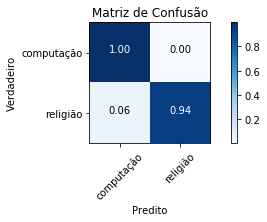

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

params = {'lr__C': [100, 1000, 5000, 10000]}
pipeline = Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                           ('variancethreshold', VarianceThreshold(1e-4)),
                           ('lr', LogisticRegression())])

grid = GridSearchCV(pipeline, params, cv=5)

train_and_report(grid,
                 train=(x_train, y_train),
                 test=(x_test, y_test),
                 classes=target_names)

**Reporte a ROC AUC sobre o conjunto de teste.**

In [7]:
from sklearn.metrics import roc_auc_score

metric_lr = roc_auc_score(y_test, grid.best_estimator_.predict(x_test))
print('ROC:', metric_lr)

ROC: 0.9670584379699007


### Visualizando o conjunto após a transformação

In [8]:
# Resgata o modelo com os parâmetros de melhor pontuação sobre as
# dobras de validação, retreinado sobre todo o conjunto de treino.
model = grid.best_estimator_

**Você usou o pipeline no passo anterior?**

In [9]:
pipeline_used = True  # altere aqui se necessário

if pipeline_used:
    transformers = model.steps[:2]
else:
    tfidf = TfidfVectorizer(stop_words='english') # substitua por seu transformador TF-IDF.
    vt = VarianceThreshold(1e-4) # substitua por seu seletor de features baseado em variância.
    transformers = [
        ('tfidfvectorizer', tfidf),
        ('variancethreshold', vt),
    ]

In [10]:
from sklearn.pipeline import Pipeline

# Cria um novo pipeline com o TF-IDF e o seletor de características.
transformer = Pipeline(transformers)
t_train = transformer.transform(x_train)

print('Número de características após transformação TF-IDF:',
      transformer.named_steps['tfidfvectorizer'].transform(x_train).shape[1])
print('Número de características após seleção de características:', t_train.shape[1])

Número de características após transformação TF-IDF: 73313
Número de características após seleção de características: 2151


In [11]:
print('Estatísticas sobre a variância das características antes e após a seleção:')

vt = transformer.named_steps['variancethreshold']
chosen_features = vt.get_support()

var_stats = pd.concat((pd.Series(vt.variances_).describe(),
                       pd.Series(vt.variances_[chosen_features]).describe()),
                      axis=1)
var_stats.columns = ['original', 'selected']
display(var_stats.T)

Estatísticas sobre a variância das características antes e após a seleção:


,count,mean,std,min,25%,50%,75%,max
original,73313.0,0.000013,0.000051,4.201039e-12,2.123443e-08,4.164560e-07,0.000007,0.003181
selected,2151.0,0.000223,0.000190,1.000281e-04,1.245993e-04,1.631092e-04,0.000247,0.003181


**Exibindo um *embedding* para o conjunto:**

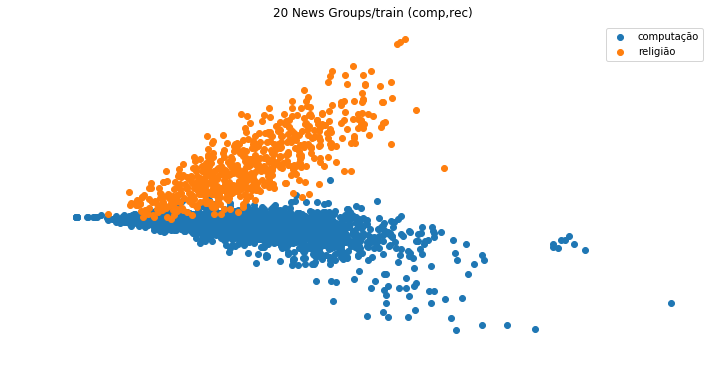

In [ ]:
show_datasets(t_train, y_train.astype(int),
              target_names,
              title='20 News Groups/train (comp,rec)')

## Redução de dimensionalidade

1. **Utilize o `Non-Negative Matrix Factorization (NMF)` para reduzir a dimensionalidade do conjunto 20 news groups binarizado e vetorizado (mas não reduzido com a seleção de características) acima.**
2. **Utilize um classificador baseado no algoritmo Random Forest, buscando pelo número de árvores no intervalo *(100, 500)*.**

Dica: use um `GridSearchCV#n_jobs` pequeno aqui.

In [ ]:
from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestClassifier

params = {'rf__max_depth': [100, 200, 300, 400, 500], 'nmf__n_components':[5,10]}
pipeline = Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                           ('nmf', NMF(init='random', random_state=0)),
                           ('rf', RandomForestClassifier())])

grid = GridSearchCV(pipeline, params, cv=5, n_jobs=2, verbose=2)

train_and_report(grid,
                 train=(x_train, y_train),
                 test=(x_test, y_test),
                 classes=target_names)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] nmf__n_components=5, rf__max_depth=100 ..........................
[CV] nmf__n_components=5, rf__max_depth=100 ..........................
[CV] ........... nmf__n_components=5, rf__max_depth=100, total=   4.7s
[CV] nmf__n_components=5, rf__max_depth=100 ..........................
[CV] ........... nmf__n_components=5, rf__max_depth=100, total=   5.4s
[CV] nmf__n_components=5, rf__max_depth=100 ..........................
[CV] ........... nmf__n_components=5, rf__max_depth=100, total=   5.6s
[CV] nmf__n_components=5, rf__max_depth=100 ..........................
[CV] ........... nmf__n_components=5, rf__max_depth=100, total=   5.8s
[CV] nmf__n_components=5, rf__max_depth=200 ..........................


**Reporte a ROC AUC sobre o conjunto de teste:**

In [ ]:
from sklearn.metrics import roc_auc_score

metric_rf = roc_auc_score(y_test, grid.best_estimator_.predict(x_test))
print('ROC:', metric_rf)

**Qual dos dois conjuntos de algoritmos apresentou o melhor resultado?**

In [ ]:
if(metric_rf  > metric_lr):
    res="Randon Forest"
else:
    res="Linear Regression"
print("O conjunto que apresentou o melhor resultado foi o:",res)

**Verifique se combater o desbalanceamento das classes em treino ao ponderar as amostras pelo inverso das frequências de suas classes (utilizando o parâmetro `class_weight='balanced'`) melhora os resultados:**

In [ ]:
from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestClassifier

params = {'rf__max_depth': [100, 200, 300, 400, 500], 'nmf__n_components':[5, 10]}
pipeline = Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                           ('nmf', NMF(init='random', random_state=0)),
                           ('rf', RandomForestClassifier(class_weight='balanced'))])

grid = GridSearchCV(pipeline, params, cv=5, n_jobs=2)

train_and_report(grid,
                 train=(x_train, y_train),
                 test=(x_test, y_test),
                 classes=target_names)